In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [493]:
# Open data with wind
train = pd.read_csv('../../data/processed/train_with_wind.csv', sep=',')
test = pd.read_csv('../../data/processed/test_with_wind.csv', sep=',')

In [494]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
dtype: int64

In [495]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
year          0
month         0
day           0
hour          0
dtype: int64

In [496]:
# Create dummy variables to recoginse the datasets
train['dataset'] = 'train'
test['dataset'] = 'test'

# Combine train and test based on the datetime column
data = pd.concat([train, test], axis=0)
data.sort_values('datetime', inplace=True)

#reset_index
data.reset_index(drop=True, inplace=True)

In [497]:
data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
year             0
month            0
day              0
hour             0
dataset          0
dtype: int64

In [498]:
mask = data['dataset'] == 'train'

In [499]:
def smooth_data(data, features, window_sizes):
    for i, feature in enumerate(features):
        min_periods = int(np.ceil(window_sizes[i]/2))
        data[feature] = data[feature].rolling(window=window_sizes[i], min_periods= min_periods, center = True).mean()
    return data

# Smooth data
features = ['temp', 'atemp', 'humidity', 'windspeed']
window_sizes = [3, 3, 3, 3, 3, 3, 3, 3, 3]
data = smooth_data(data, features, window_sizes)

# Smooth train data
features = ['count', 'registered', 'casual']
window_sizes = [3, 3, 3]

In [500]:
data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
year             0
month            0
day              0
hour             0
dataset          0
dtype: int64

ADF Statistic for count: -6.419975656501509
count is stationary



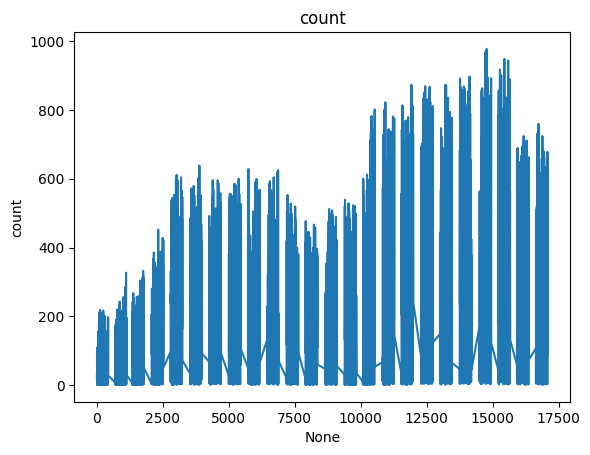

ADF Statistic for registered: -7.475669726156094
registered is stationary



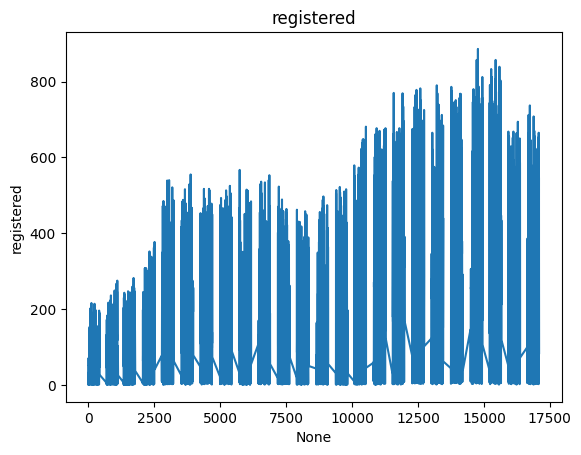

ADF Statistic for casual: -10.383742730117927
casual is stationary



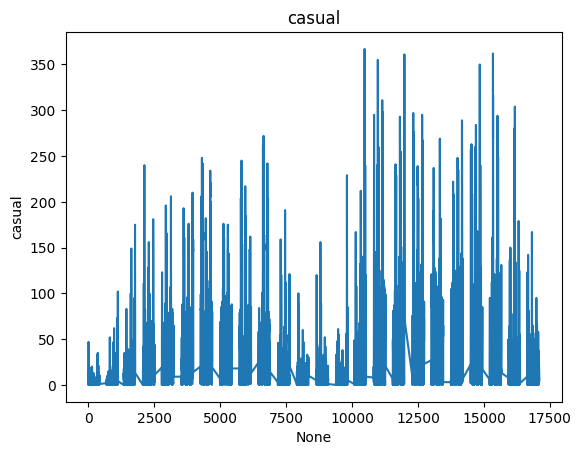

In [501]:
# check stationarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(dataset, columns):
    stationary_results = {}
    
    for col in columns:
        result = adfuller(dataset[col])
        print(f'ADF Statistic for {col}: {result[0]}')
        stationary_results[col] = {'ADF Statistic': result[0],
                                   'p-value': result[1],
                                   'Critical Values': result[4]}
        # Print weather the data is stationary or not
        if result[1] < 0.05:
            print(f'{col} is stationary\n')
        else:
            print(f'{col} is not stationary\n')

        # Plot data with seaborn with index as x
        sns.lineplot(data=dataset, x=dataset.index, y=col)
        plt.title(col)
        plt.show()
        
    return stationary_results

# Check stationarity
columns = ['count', 'registered', 'casual']
stationarity_results = check_stationarity(data[mask], columns)


In [502]:
data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
year             0
month            0
day              0
hour             0
dataset          0
dtype: int64

In [503]:
def remove_outliers(data, features):

    # Create a new copied column for each feature
    for feature in features:
        data[f'{feature}_orig'] = data[feature].copy()

        # Calculate the z-score
        data[f'{feature}_zscore'] = np.abs((data[feature] - data[feature].mean())/data[feature].std())

        # Set to NaN values that are outliers
        data.loc[data[f'{feature}_zscore'] > 3, feature] = np.nan
        
    return data

# Remove outliers
features = ['count', 'registered', 'casual']
train = data[mask].copy()
data[mask] = remove_outliers(train, features)

In [504]:
data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6785
registered    6728
count         6640
year             0
month            0
day              0
hour             0
dataset          0
dtype: int64

In [505]:
def interpolate_outliers(data, features):
    for feature in features:
        data[feature] = data[feature].interpolate(method='spline', order=3)
    return data

# Interpolate outliers
train = data[mask].copy()
data[mask] = interpolate_outliers(train, features)

In [506]:
# convert datetime to datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [507]:
data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
year             0
month            0
day              0
hour             0
dataset          0
dtype: int64

In [508]:
# Add day of the year number from 1 to 365
data['dayofyear'] = data['datetime'].dt.dayofyear

# Add week of the year number from 1 to 52
data['weekofyear'] = data['dayofyear'] // 7
# Add day of the week
data['dayofweek'] = data['datetime'].dt.dayofweek

In [509]:
data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
year             0
month            0
day              0
hour             0
dataset          0
dayofyear        0
weekofyear       0
dayofweek        0
dtype: int64

In [510]:
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dataset', 'dayofyear', 'weekofyear',
       'dayofweek'],
      dtype='object')

In [511]:
def create_lagged_features(data, features, lags):
    
    for feature in features:
        for lag in lags:

            current = data[feature]
            positive_lag = current.shift(lag)
            negative_lag = current.shift(-lag)

            mask_positive = positive_lag.isnull()
            mask_negative = negative_lag.isnull()
            mask_double = mask_positive & mask_negative

            positive_lag[mask_positive & (~mask_double)] = current[mask_positive] + (current - negative_lag)[mask_positive]
            negative_lag[mask_negative & (~mask_double)] = current[mask_negative] + (current - positive_lag)[mask_negative]

            data[f'{feature}, +{lag}'] = positive_lag
            data[f'{feature}, -{lag}'] = negative_lag
    return data

# Create lagged features
features = ['windspeed', 'atemp', 'humidity', 'holiday', 'workingday', 'weather', 'temp']
days_of_lag = [7]
lags = [day * 24 for day in days_of_lag]

data = create_lagged_features(data, features, lags)

features = ['casual', 'registered']
days_of_lag = [6, 7, 8]
lags = [day * 24 + i for day in days_of_lag for i in (-1, 0, 1)]
data = create_lagged_features(data, features, lags)

In [512]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,"registered, +168","registered, -168","registered, +169","registered, -169","registered, +191","registered, -191","registered, +192","registered, -192","registered, +193","registered, -193"
0,2011-01-01 00:00:00,1,0,0,1,9.430000,14.015000,80.500000,6.496104,3.0,...,18.0,8.0,11.0,15.0,25.0,1.0,21.0,5.0,16.0,10.0
1,2011-01-01 01:00:00,1,0,0,1,9.293333,13.888333,80.333333,6.492727,8.0,...,49.0,15.0,44.0,20.0,59.0,5.0,54.0,10.0,45.0,19.0
2,2011-01-01 02:00:00,1,0,0,1,9.293333,13.888333,78.333333,6.153690,5.0,...,34.0,20.0,-2.0,56.0,44.0,10.0,35.0,19.0,5.0,49.0
3,2011-01-01 03:00:00,1,0,0,1,9.566667,14.141667,76.666667,7.400227,3.0,...,-36.0,56.0,-40.0,60.0,1.0,19.0,-29.0,49.0,-27.0,47.0
4,2011-01-01 04:00:00,1,0,0,1,9.840000,13.890000,75.000000,7.239303,0.0,...,-58.0,60.0,-88.0,90.0,-47.0,49.0,-45.0,47.0,-77.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.660000,13.131667,56.000000,10.333633,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.660000,12.880000,60.000000,11.001400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.660000,13.131667,58.666667,10.333633,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.660000,13.383333,60.333333,9.665867,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [515]:
# make list of columns that are never nan from data.columns
columns = data.columns
columns = columns[~data.isnull().any()]

columns_to_fill = data.columns[~data.columns.isin(columns)]

In [516]:
print(f'Columns that are never NaN: {columns}')
print(f'Columns that have NaN: {columns_to_fill}')

Columns that are never NaN: Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dataset', 'dayofyear', 'weekofyear', 'dayofweek', 'windspeed, +168',
       'windspeed, -168', 'atemp, +168', 'atemp, -168', 'humidity, +168',
       'humidity, -168', 'holiday, +168', 'holiday, -168', 'workingday, +168',
       'workingday, -168', 'weather, +168', 'weather, -168', 'temp, +168',
       'temp, -168'],
      dtype='object')
Columns that have NaN: Index(['casual', 'registered', 'count', 'casual, +143', 'casual, -143',
       'casual, +144', 'casual, -144', 'casual, +145', 'casual, -145',
       'casual, +167', 'casual, -167', 'casual, +168', 'casual, -168',
       'casual, +169', 'casual, -169', 'casual, +191', 'casual, -191',
       'casual, +192', 'casual, -192', 'casual, +193', 'casual, -193',
       'registered, +143', 'registered, -143', 'registered, +144',
       'registered, -144', 'reg

In [ ]:
# Create piplines to fill missing values with mlp regressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# Create a pipeline to fill missing values

def create_pipeline(data, feature):
    # Create a mask to identify the missing values
    mask = data[feature].isnull()
    
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000))
    ])
    
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(data[~mask].drop(columns=columns_to_fill, axis=1), data[~mask][feature], test_size=0.2)
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict the missing values
    data.loc[mask, feature] = pipeline.predict(data[mask].drop(columns=columns_to_fill, axis=1))
    
    return data

In [514]:
# save data
data.to_csv('../../data/processed/final_data.csv', index=False)